In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [12]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
eps_rel = 1 #relative permittivity
eps = eps0 * eps_rel
k = 1/(4*math.pi*eps)
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [13]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def intertia( rho, thc, Rp, p):
    """Calculates inertia of inner rotating section (rotor)"""
    m_cog = rho*thc*w*r
    m_disc = math.pi * ((Rp-r)**2)*thc*rho
    I = m_cog*((r**2) + (w**2)) + p*m_cog*((Rp-(r/2))**2) + m_disc*((Rp-r)**2)
    return I

In [14]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (r/2) * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e
        elif i in range(3, n, 4):
            q_ch = -noc*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [15]:
"""Active motor functions"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge edge
        ric = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge center
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        '''Alpha is alpha at edge of permanent charge'''
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha        
        '''Alphac is alpha at center of permanent charge'''
        if ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) > 1 or ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) < -1 : #accounts for computational error
            alphac = 0
        else:
            alphac = math.acos((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) #angle to tangential in which force vector acts
        if i > n/2:
            alphac = -alphac
        ex_minus = ri*math.sin(alpha) - (width/2)
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alphac)
    return F_t

def force( c1, c2, c3, c4):
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

def Charging_time( R, C):
    "Computes charging time for dot and capacitor"
    tc = 4 * R * C
    return tc

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    #print( E_cQD )
    #print( E_cC )
    E_intotal = (E_cQD * n) + ( (n/2) * (E_l + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    return angv * torque

def Output_energy(angv, I):
    E_out = 0.5 * I * (angv**2)
    return E_out

def efficiency(E_in, E_out):
    eff = (E_out/E_in)
    return eff

In [16]:
'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]"""Initial parameters:"""
'''Test lists'''
n_list = []
p_list = []
phi_list = []
R_list = []
Rp_list = []
width_list = []
r_list = []
I_list = []
color_list = ['b', 'g', 'r', 'c', 'm', 'y']

'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
r0 = 110e-9
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
i=0
for n in np.arange(4, 200, 4):
    PHI = seperation_angle(n) #angle of seperation between QDs
    phi_list.append(PHI)
    R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
    R_list.append(R)
    Rp = R - r0   #radius of rotating disc [m]
    Rp_list.append(Rp)
    w = width( Rp, PHI ) #cog "tooth"/capacitor arm width [m]
    width_list.append(w)
    r = cog_length( Rp, PHI)    #length of the cog shaft [m]
    r_list.append(r)
    p = int(n/2)
    p_list.append(p)
    I = intertia( rho, thc, Rp, p) #inertia of inner rotating disk
    I_list.append(I)
    n_list.append(n)

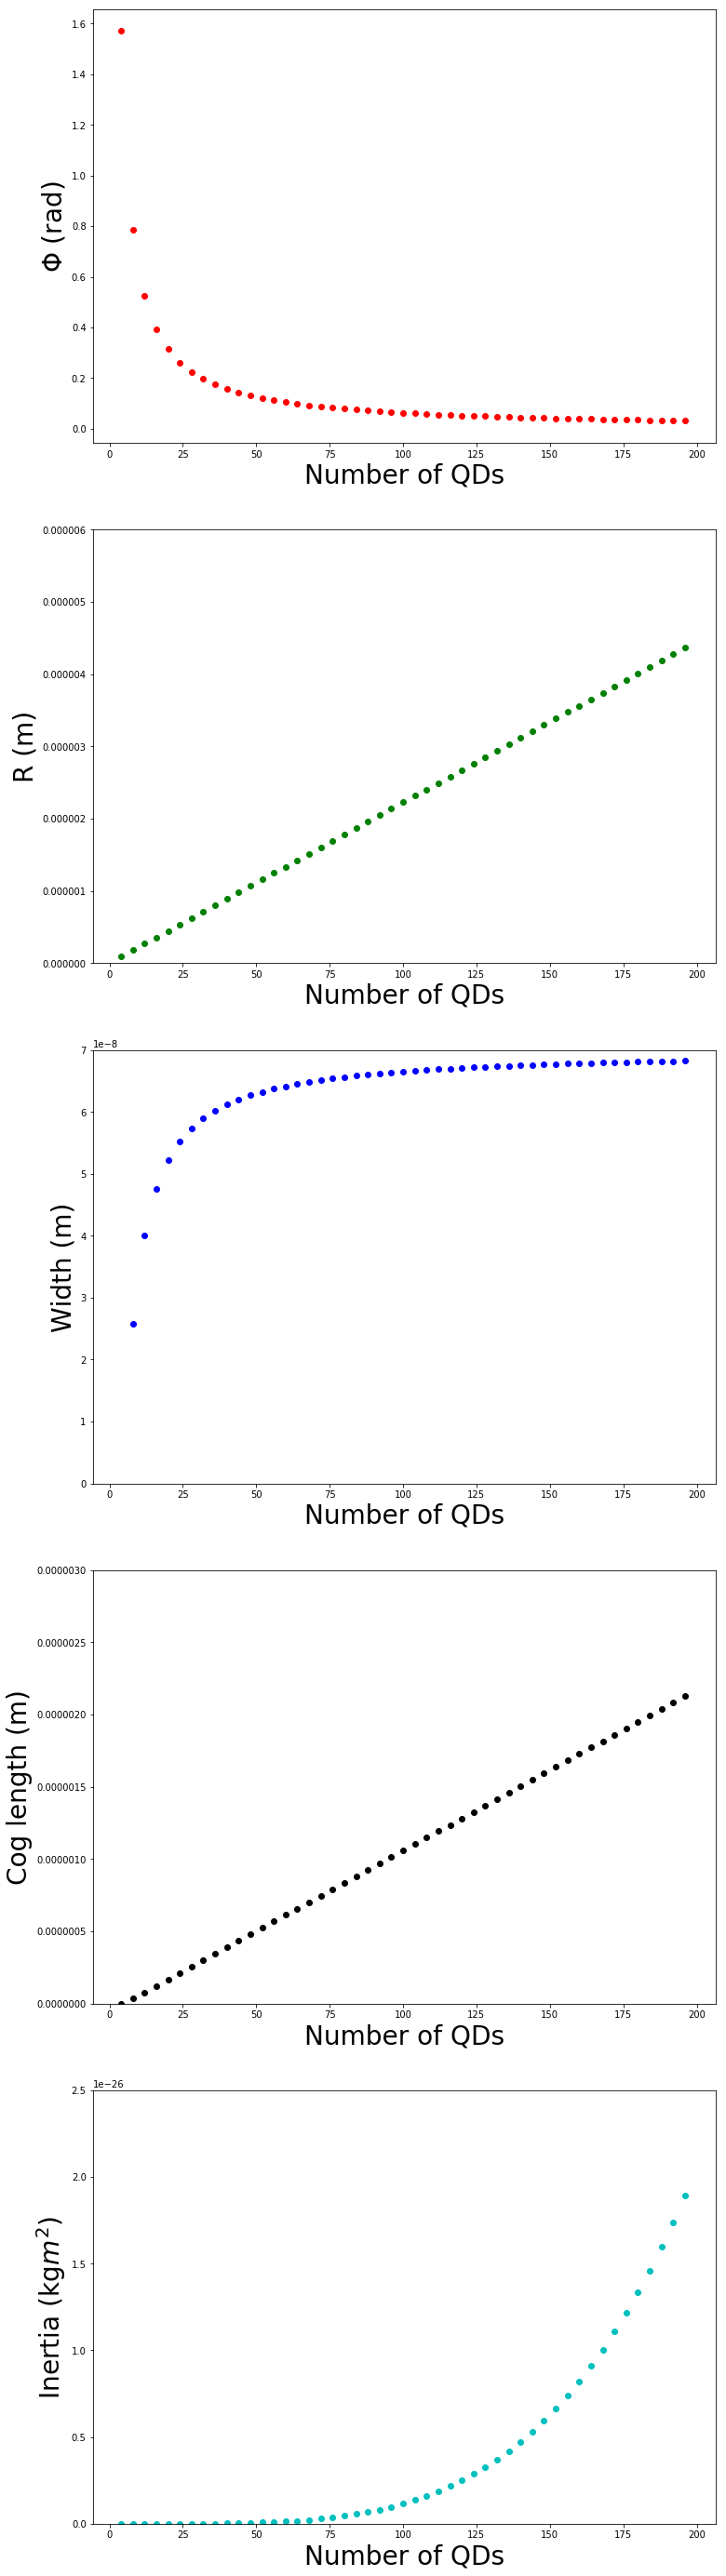

In [20]:
fig = plt.figure(figsize=(12, 60))
ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
#ax6 = fig.add_subplot(336)
ax1.set_xlabel('Number of QDs', fontsize = '28')
ax1.set_ylabel('$\Phi$ (rad)', fontsize = '28')
ax2.set_xlabel('Number of QDs', fontsize = '28')
ax2.set_ylabel('R (m)', fontsize = '28')
ax2.set_ylim( 0 , 0.6e-5)
ax3.set_xlabel('Number of QDs', fontsize = '28')
ax3.set_ylabel('Width (m)', fontsize = '28')
ax3.set_ylim( 0 , 70e-9)
ax4.set_xlabel('Number of QDs', fontsize = '28')
ax4.set_ylabel('Cog length (m)', fontsize = '28')
ax4.set_ylim( 0 , 0.3e-5)
ax5.set_xlabel('Number of QDs', fontsize = '28')
ax5.set_ylabel('Inertia (kg$m^2$)', fontsize = '28')
ax5.set_ylim( 0 , 0.25e-25)
#ax6.set_xlabel('n', fontsize = '20')
#ax6.set_ylabel('n', fontsize = '20')
i=0
for n in np.arange(4, 200, 4):
    ax1.scatter(n_list[i], phi_list[i] , color = 'r')
    ax2.scatter(n_list[i], R_list[i] , color = 'g')
    ax3.scatter(n_list[i], width_list[i] , color = 'b')
    ax4.scatter(n_list[i], r_list[i] , color = 'k')
    ax5.scatter(n_list[i], I_list[i] , color = 'c')
    i+=1

plt.show()

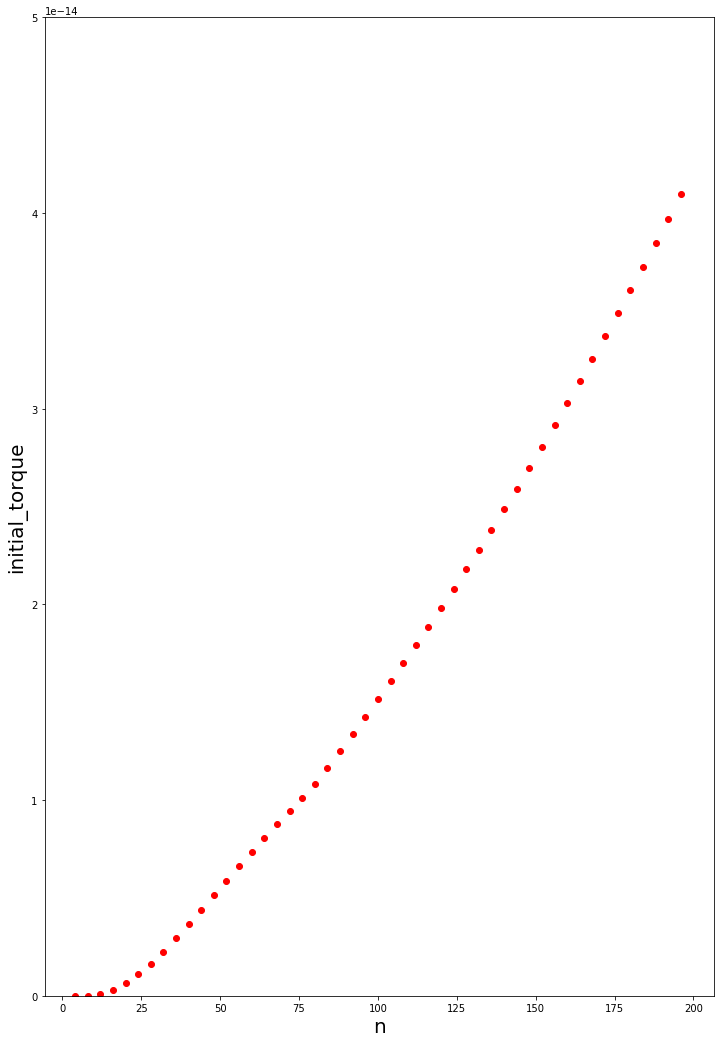

In [17]:
"""Main function"""

fig = plt.figure(figsize=(12, 18))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('n', fontsize = '20')
ax1.set_ylabel('initial_torque', fontsize = '20')
ax1.set_ylim( 0 , 5e-14)

"""Plot"""
j=0
for n in np.arange(4, 200, 4):
    PCs = permanent_charges( Rp_list[j], p_list[j] , cap_d, cap_vol, width_list[j], r_list[j]) #initializes permanent charges
    T = 0
    F_t = tangential_component(k , n_list[j], e, R_list[j], Rp_list[j], 0, noc, width_list[j], r_list[j])
    T = torque(F_t, Rp_list[j], p_list[j], r_list[j]) #calculates torque acting on inner rotor at gamma = 0
    ax1.scatter( n_list[j], T, color = 'r')
    j+=1
    
plt.show()